<a href="https://colab.research.google.com/github/JollygreenG-10/Prediction-of-House-Prices/blob/main/WorkingV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab import files
import seaborn as sns
uploaded = files.upload() 

Saving test.csv to test.csv
Saving train.csv to train.csv


# Executive Summary

Completion of a kaggle submission for housing price predictions involved data maniuplation and cleaning, exploratory analysis, model feature selection, model training and finally, model prediction. This process was supported by resources including in-class colab notebooks for multiple linear regression and subset selection, Toward Data Science articles (links below), and previous personal code for multiple linear regression. Data manipulation included reading training and test data, setting features and labels and handling NA values using methods including dummy variable encoding. Analysis of the transformed trainng data was then completed to explore relationships between predictors and log sale price. Data plotting was completed during this step including scatterplots to determine correlation with log sale price and histograms to explain variable distributions.  Finally, using knowledge gained from exploratory data analysis, the datasets were cleaned to remove predictors deemed unneccesary, ordinal variables were label encoded and categorical predictors were converted to dummy variables in both the training and final test datasets. Forward stepwise feature selection was then completed with the resulting model carrying 56 predictors (R^2 = 0.87). The best kaggle submission score achieved was 0.15126. This score was achieved for a past iteration of the modelling process. An updated value could not be generated for the most updated strategy as Kaggle is having technical difficulties related to phone verification and prevented me from submitting further attempts. 
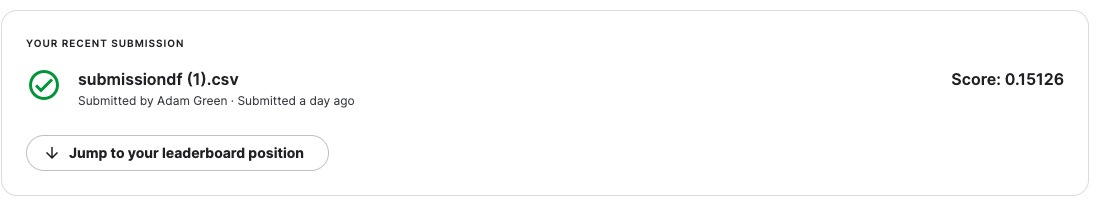


References: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e

https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b


# Ethics Discussion

Through exploration and analysis of the Iowa housing dataset, a number of potential ethical issues were apparent. First, handling of NA values presented a possible source of bias.  The dataset carried a significant number of NA values across numerous columns. While the efforts to handle these values generally avoided potential bias (converting NA to the column mean, converting NA to 0 to indicate the absence of a feature where applicable), certain rows containing NA values were dropped entirely from the dataset when the source of the NA was unclear. This removal process poses a potential source of bias depending on the data points carried in the dropped rows as it could lead to an altered training process and potential misrepresentation of the variable distributions. Further, potential ethical issues could arise when interpreting the trained model in a real-world context. Due to the high dimensionality of the dataset, accurate interpretation of the model is exceedingly difficult. This means that extending the model for use in real-world applications without proper understanding could lead to inaccurate inferences and poor housing price apparaisals (ie. Certain house features could be under- or over-valued when identifying the importance of house renovations). Finally, intrisic to the dataset, ethical issues are present in the subjective rating of many housing features.  Certain predictors such as overall house quality and condition are scored based on the researcher's appraisal.  These subjective ratings could potentially reflect implicit biases held by the researchers and give way to under- or over-valuations of housing based on the ratings provided.    

In [4]:
#Read data and convert response column to log()
train3 = pd.read_csv('train.csv')
test3 = pd.read_csv('test.csv')

test_noId = test3.drop(['Id'], axis = 1)
train3['logSales'] = np.log(train3['SalePrice'])
train3 = train3.drop(['Id', 'SalePrice'], axis = 1)

features = train3
features['train_code'] = 1
test_noId['train_code'] = 0

dfs = [features, test_noId]
full_set = pd.concat(dfs)
print(len(full_set.columns))

81


# Detailed Report
### Data cleaning and EDA
To begin the cleaning/EDA process, the dataset was explored to determine datatypes for predictors as well as predictor distributions (seen below the following code block). Next, predictors with high proportions of NA values (>60%) were removed from the dataset as well as predictors that were derived from or strongly correlated with other variables. Additional recognition of unneccessary predictors was completed using the histograms and scatterplots visualized below.  Columns found to be uncorrelated with log sale price and columns with one prevailing value were included in the *removal* list.

In [5]:
#describe the dataset
print(full_set.info())
print(full_set.describe())

def drop_col(col):
  full_set.drop([col], inplace = True, axis = 1)

continuous_cols = []
cat_cols = []
for i in full_set.columns:
  if full_set[i].dtype == 'int64' or full_set[i].dtype == 'float64':
    continuous_cols.append(i)
  if full_set[i].dtype == 'object':
    cat_cols.append(i)

#remove columns with > 60% NA
for j in full_set.columns:
  na_prop = (full_set[j].isna().sum())/len(full_set[j])
  if na_prop > 0.6:
    print(f'{j} was removed from the feature list')
    drop_col(j)

#removal of correlated columns
removal = ['BsmtFinType1',"BsmtFinSF1","BsmtFinSF2", "BsmtFinType2", 'BsmtUnfSF', 'Electrical', 
           "YearBuilt", 'OverallQual', 'OverallCond',
           '1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'GarageType',
           'GarageFinish', 'GarageCars', 'SaleCondition', 'MSZoning', 'Utilities', 
           'LowQualFinSF', 'Functional', '3SsnPorch', 'PoolArea','BldgType', 'BsmtFullBath', 
           'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal', 'MoSold'] 
#drop correlated and unneccessary columns
for entry in removal:
  drop_col(entry)
print(f'{len(full_set.columns)} features remain in the dataset')



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

# Detailed Report (Continued)
After initial cleaning, ordinal variables were label encoded while remaining NA values in the dataset were converted to either 0 or the column mean depending on the predictor in question. Additionally, remaining categorical variables were converted to dummy variables.  This process produced a dataset of 200 columns.  Across other model building trials, attempted strategies also included removing all variables that are uncorrelated with log sale price (corr < 0.5), as well as using no encoding and only implementing dummy variables. The current method was found most effective in producing a dataset with manageable dimensionality.

In [6]:
#label encoding
ordinal_cols = ['BsmtExposure', 'BsmtQual', 'BsmtCond', 
                'ExterQual', 'ExterCond', 'FireplaceQu',
                'HeatingQC', 'GarageQual', 'GarageCond', 'PavedDrive', 'KitchenQual']


#create encoding dictionaries
encoding_libQual = {'TA': 2, 'Fa': 1, 'Gd':3, 'Ex':4 , 'Po': 0, }
encoding_libPave = {'Y':2, 'N':0, 'P':1}
encoding_libExp = {'No':0, 'Gd':3, 'Mn':1, 'Av':2}

qual = ['BsmtCond','BsmtQual', 'ExterQual', 'ExterCond', 'FireplaceQu','HeatingQC', 'GarageQual', 'GarageCond','KitchenQual']
pave = ['PavedDrive']
exp = ['BsmtExposure']

#map corresponding dictionaries
def map_codes(col, dic):
  for cols in col:
    full_set[cols] = full_set[cols].map(dic)

map_codes(qual, encoding_libQual)
map_codes(pave, encoding_libPave)
map_codes(exp, encoding_libExp)

#handle nan values in ordinal columns
for i in ordinal_cols:
  full_set[i].fillna(-1, inplace = True)

#Handle NA values for other columns 
def counter(df, col_name):
  return (df[col_name].isna().sum())

replace_na_columns = ['MasVnrArea', 'LotFrontage', 'GarageArea']
def clean_data2(df):
  for k in replace_na_columns:
    df[k] = df[k].fillna(0)
  df['MasVnrType'] = df['MasVnrType'].fillna("None")
  meanBsmtSf = np.mean(df['TotalBsmtSF'])
  df["TotalBsmtSF"] = df["TotalBsmtSF"].fillna(meanBsmtSf)
  df.dropna(axis = 0, subset = ["TotalBsmtSF", 'Exterior1st', 'Exterior2nd', 'SaleType'])
  df = pd.get_dummies(df, dummy_na = True)
  return(df)

#produce cleaned dataset
cleaned_set = clean_data2(full_set)

#review to ensure no NA remaining
for i in cleaned_set.columns:
  na_counter = counter(cleaned_set,i)
  if na_counter > 0:
    print(f"the column {i} has {na_counter} NA values")


the column logSales has 1459 NA values
189


# Detailed report (Continued)
After cleaning was complete, scatterplots and historgrams were produced using remaining predictors.  Scatterplots with correlation scores allowed for visual recognition of unneccesary predictors while histograms visualized predictor distributions and value counts.  Both processes were used to visually identify other predictors that could be removed from the dataset. Removed predictors include: 


MSSubClass         int64
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
HouseStyle        object
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual          int64
ExterCond          int64
Foundation        object
BsmtQual         float64
BsmtCond         float64
BsmtExposure     float64
TotalBsmtSF      float64
Heating           object
HeatingQC          int64
CentralAir        object
GrLivArea          int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenQual      float64
TotRmsAbvGrd       int64
Fireplaces         int64
FireplaceQu      float64
GarageArea       float64
GarageQual       float64
GarageCond       float64


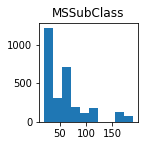

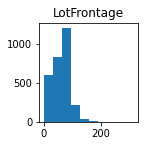

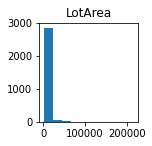

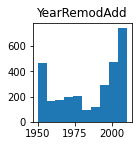

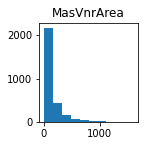

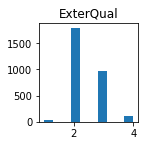

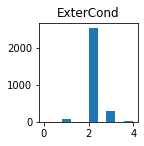

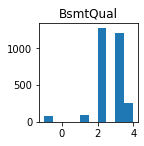

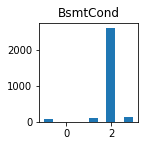

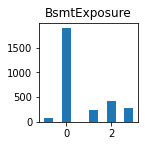

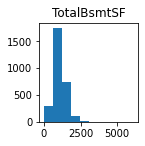

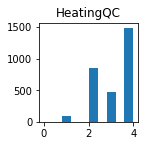

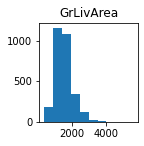

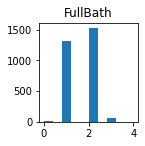

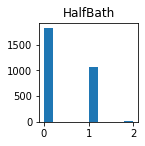

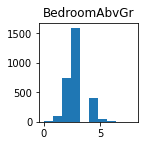

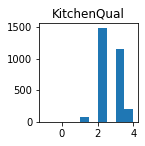

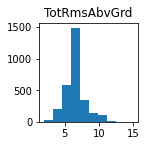

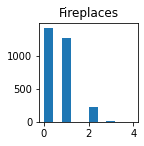

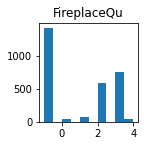

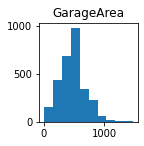

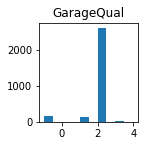

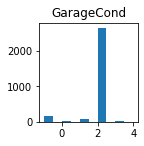

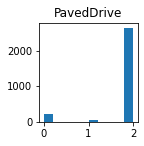

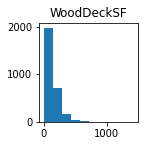

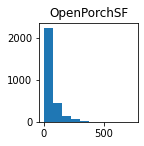

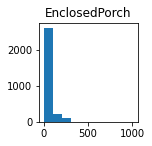

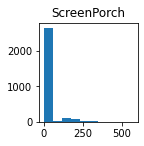

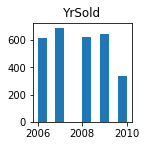

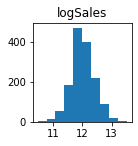

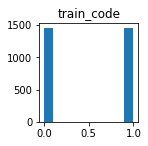

In [7]:
#Histograms to assess predictor distributions and value counts
print(full_set.dtypes)
key_columns = []
for j in cleaned_set.columns:
  if cleaned_set[j].dtype == 'int64' or cleaned_set[j].dtype == 'float64':
    key_columns.append(j)

for i, col in enumerate(key_columns):
  plt.subplot(2, 3, 3)
  plt.hist(cleaned_set[col])
  plt.title(col)
  plt.show()
    

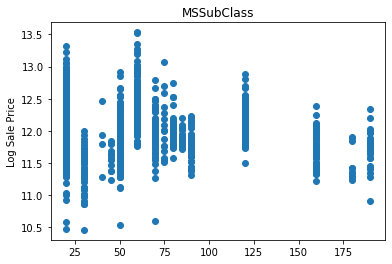

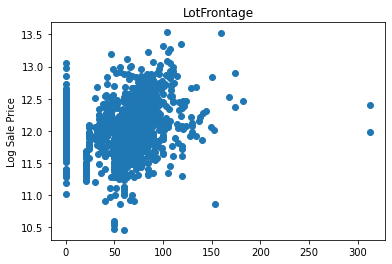

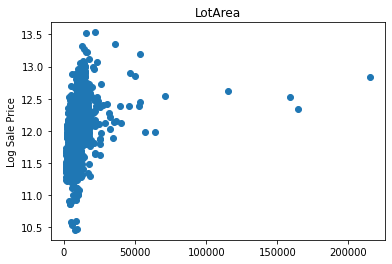

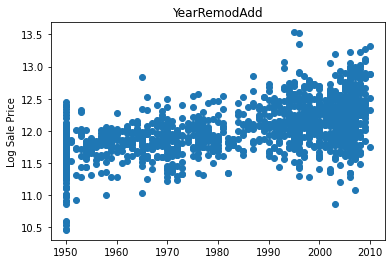

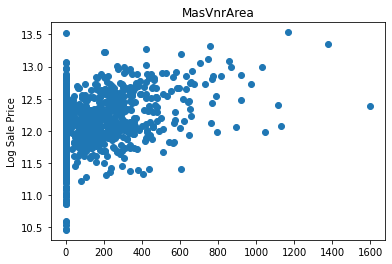

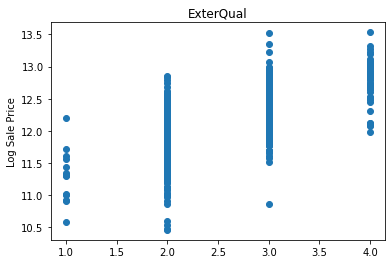

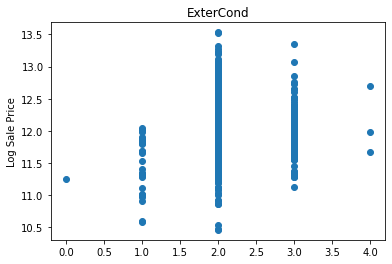

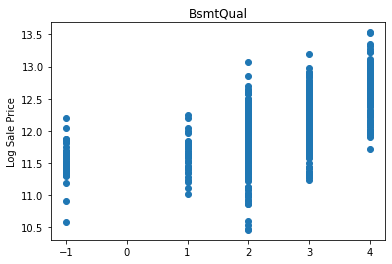

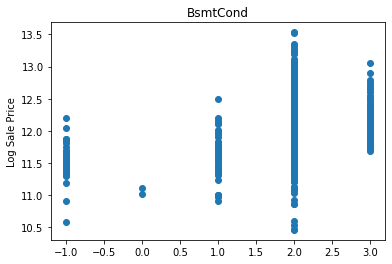

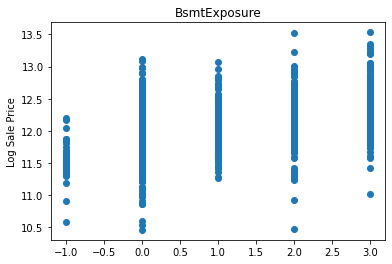

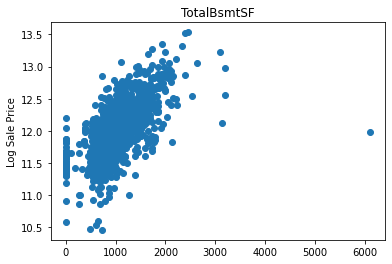

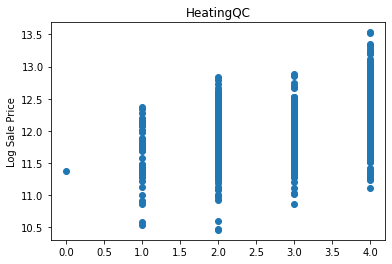

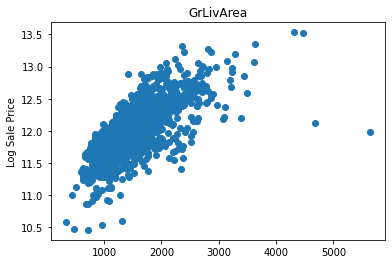

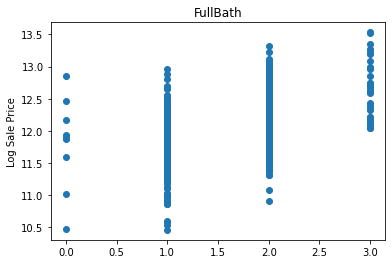

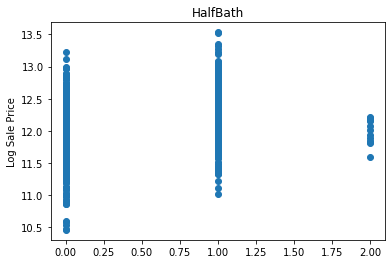

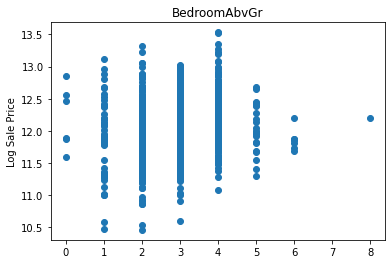

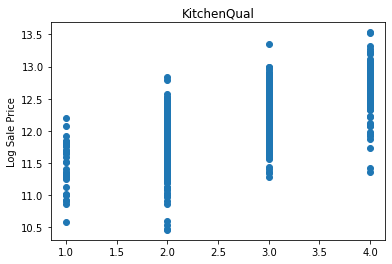

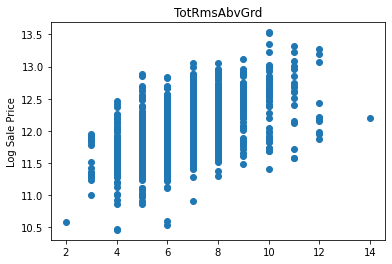

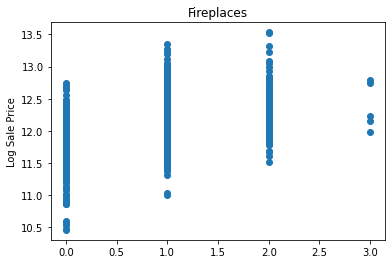

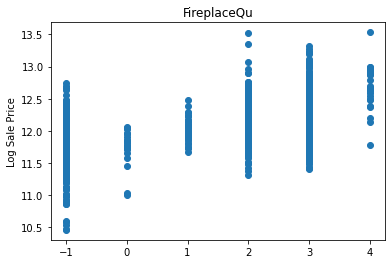

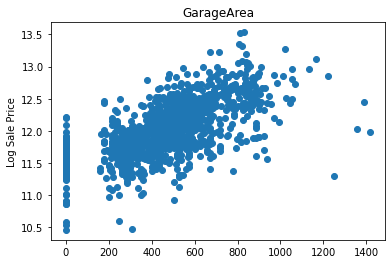

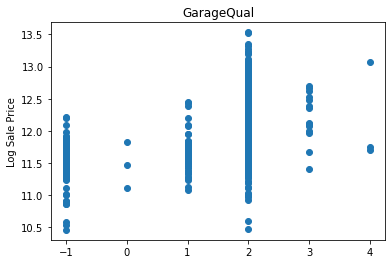

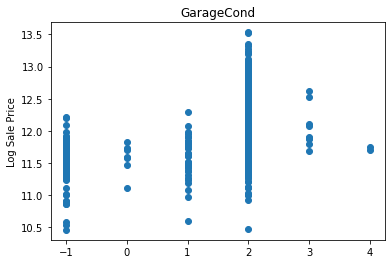

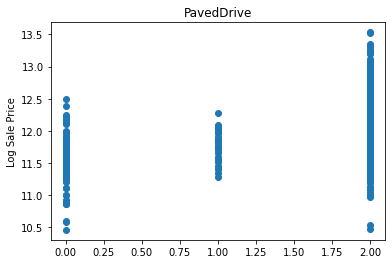

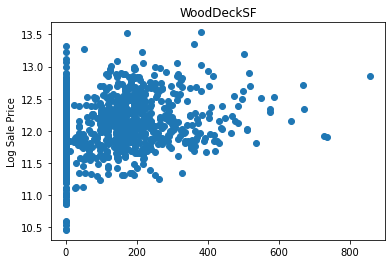

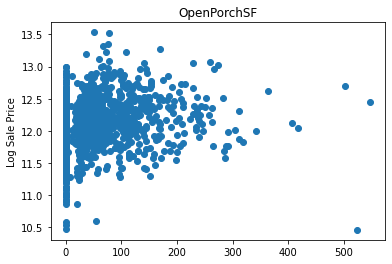

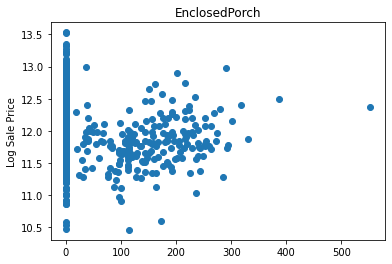

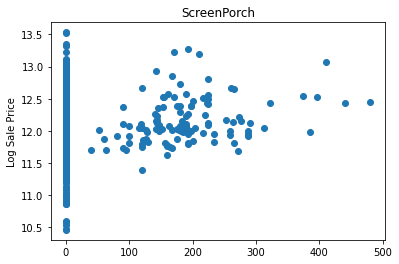

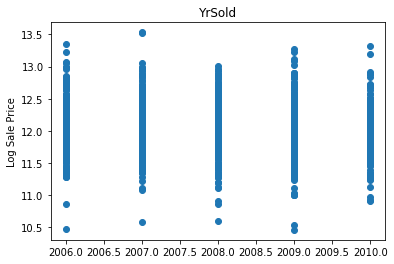

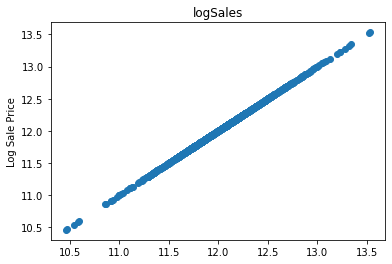

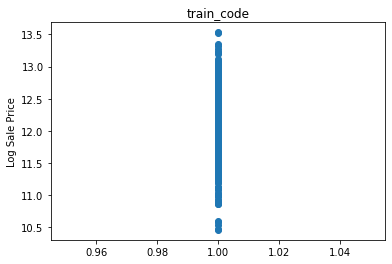

In [8]:
#EDA for final feature selection using scatterplots
trainer = cleaned_set.query('train_code == 1')

for feat in trainer.columns:
  if trainer[feat].dtype == 'int64' or trainer[feat].dtype == 'float64': 
    plt.scatter(trainer[feat], trainer['logSales'])
    plt.ylabel("Log Sale Price")
    plt.title(feat)
    plt.show()


# Detailed Report (Continued)



In [9]:
#removing Correlated columns
cor_set = set()
cor_data = full_set.drop(['logSales'], axis = 1)
cor_matrix = cor_data.corr()

for x in range(len(cor_matrix.columns)):
  for z in range(x):
    if abs(cor_matrix.iloc[x, z]) > 0.8:
            colname = cor_matrix.columns[x]
            cor_set.add(colname)
print(cor_set)
cleaned_set = cleaned_set.drop(list(cor_set), axis =1)

{'GarageCond', 'TotRmsAbvGrd', 'FireplaceQu'}


Code for correlated feature extraction sampled from https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/


# Detailed Report (Continued)
### Feature Selection and model training 
Using the remaining predictors data was reclassified into training and final tests sets before the the training set was further split into training and validation sets. The approach highlighted in the following code block for feature selection was found to be most effective.  A second approach using the sci-kit learn feature selection package and the recursive feature elimination with cross-validation method was also applied, however, the forward selection method seen below was found to be most effective, apparent from improved R2 and MSE values. A summary of the trained model can be seen below the following code block.

In [10]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
tester = cleaned_set.query("train_code == 0").drop(['train_code', 'logSales'], axis = 1)
trainer = cleaned_set.query('train_code == 1').drop(['train_code', 'logSales'], axis = 1)
labels = cleaned_set.query('train_code == 1').drop(['train_code'], axis = 1)
labels = labels['logSales']


x_train, x_test, y_train, y_test = train_test_split(trainer, labels, test_size = 0.1, random_state = 20)
print(y_train.shape, x_train.shape, tester.shape)

def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        print(min_p_value)
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
            print(best_features)
        else:
            break
    return best_features

best_features = forward_selection(x_train, y_train)

x_train = x_train[best_features]
x_test = x_test[best_features]
tester = tester[best_features]
print(len(best_features))

updated_model = sm.OLS(y_train, x_train).fit()
print(updated_model.summary())

(1314,) (1314, 184) (1459, 184)
2.056266574986246e-196
['GrLivArea']
5.830238408976015e-119
['GrLivArea', 'KitchenQual']
2.1308826581328802e-63
['GrLivArea', 'KitchenQual', 'BsmtQual']
3.4618986188706416e-41
['GrLivArea', 'KitchenQual', 'BsmtQual', 'GarageArea']
2.46544782831628e-29
['GrLivArea', 'KitchenQual', 'BsmtQual', 'GarageArea', 'RoofMatl_ClyTile']
4.52297040627626e-25
['GrLivArea', 'KitchenQual', 'BsmtQual', 'GarageArea', 'RoofMatl_ClyTile', 'Fireplaces']
1.861442583368148e-17
['GrLivArea', 'KitchenQual', 'BsmtQual', 'GarageArea', 'RoofMatl_ClyTile', 'Fireplaces', 'YearRemodAdd']
4.5758715330532206e-23
['GrLivArea', 'KitchenQual', 'BsmtQual', 'GarageArea', 'RoofMatl_ClyTile', 'Fireplaces', 'YearRemodAdd', 'TotalBsmtSF']
1.6467674427362323e-15
['GrLivArea', 'KitchenQual', 'BsmtQual', 'GarageArea', 'RoofMatl_ClyTile', 'Fireplaces', 'YearRemodAdd', 'TotalBsmtSF', 'Neighborhood_OldTown']
3.179685317873824e-14
['GrLivArea', 'KitchenQual', 'BsmtQual', 'GarageArea', 'RoofMatl_ClyTile

Code for forward model selection sampled and adapted from https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/#:~:text=1.-,Forward%20selection,with%20all%20other%20remaining%20features

# Detailed Report (Continued)
The following code block was recorded as a trial, this feature selection and training method was not used to produce a final kaggle submission score. It is included as a sample of other strategies used for feature selection.

In [8]:
#Feature selection and training using Recursive feature elimination with cross validation
#this code is provide as an example of additional attempts at feature selection, it was not used in creating the final model
tester2 = cleaned_set.query("train_code == 0").drop(['train_code', 'logSales'], axis = 1)
trainer2 = cleaned_set.query('train_code == 1').drop(['train_code', 'logSales'], axis = 1)
labels2 = cleaned_set.query('train_code == 1').drop(['train_code'], axis = 1)

x_train1, x_test1, y_train1, y_test1 = train_test_split(trainer2, labels2, test_size = 0.1, random_state = 20)
print(y_train1.shape, x_train1.shape, tester2.shape)

estimator = LinearRegression()
min_features_to_select =1
feat_select = RFECV(estimator, step = 1, min_features_to_select=min_features_to_select)
feat_select = feat_select.fit(x_train1, y_train1)
index = feat_select.get_support(indices = True)

print(f"The optimal number of features is {feat_select.n_features_}")

(1314, 199) (1314, 198) (1459, 198)
The optimal number of features is 175


# Detailed Report (Continued)
The final step in the modelling process was model evaluation using the held-out validation test set (x_test). Evaluation of my model returned an R2 of and an MSE of.  This model was then used to make final predictions on the kaggle test data that were subsequently submitted to the kaggle competition. 

In [11]:
##model evaluation 
#Fill na in final test_set columns
for col in tester.columns:
  tester[col] = tester[col].fillna(0)


def evaluate_model(name, model, features, labels):
    pred = model.predict(features)
    model_r2 = r2_score(labels, pred)
    mse = mean_squared_error(labels, pred)
    mae = mean_absolute_error(labels, pred)
    print('{} -- model R^2: {}, MSE: {}, MAE: {}'.format(name, model_r2, mse, mae))

def counter(col_name):
  return (tester[col_name].isna().sum())
for i in tester.columns:
    na_counter = counter(i)
    if na_counter > 0:
      print(f"the column {i} has {na_counter} NA values")

evaluate_model('LR1', updated_model, x_test, y_test)



LR1 -- model R^2: 0.875389960897465, MSE: 0.01736374294119161, MAE: 0.0962193083922169


In [12]:
tester['preds'] = np.exp(updated_model.predict(tester))
submissiondf = pd.DataFrame({'Id': test3['Id'], 'SalePrice': tester['preds']})
print(submissiondf.isna().sum())
submissiondf.to_csv('submissiondf13.csv', index = False)

Id           0
SalePrice    0
dtype: int64


# Interpretations

The final model for housing price predictions included 56 predictors with all predictors included in the model having a significant contribution within the model (coefficient not equal to zero) at a 95% confidence level. Each of the predictors in the model can be interpreted to derive meaning, for example, when all other variables in the model are held constant, a single unit change in kitchen quality increases the log sale price by 0.0508. A similar interpretation can be made for each of the other variables to understand the impact of single predictors on the log sale price. The predictor with the largest impact on log sale price when a single unit change occurs is the driveway pavement status that is associated with an increase of 4 in log sale price when a single unit increase occurs in the driveway pavement status (unpaved driveway vs. paved driveway).  Beyond individual predictors, the model itself was found to have an R-squared value of 0.875 when evaluated using the validation dataset. This value indicates that 87.5% of variation in the model can be explained by the model (ie. 12.5% of variation is unexplained). Model evaluation also provided an MSE of 0.017. Overall, my model building process removed correlated predictors and predictors that showed no relationship with log sale price to create a model with 56 predictors found to significantly influence house price in Iowa. This model can now take inputs of the same datashape to predict final house price as well as allowing for inferences to be made regarding the importance of various predictors in modelling home prices. 